Employee Turnover Analytic

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
data = pd.read_csv('HR_comma_sep.csv')

In [ ]:
data.shape


(14999, 10)

In [ ]:
data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

Checking Null in the Data Set

In [ ]:
data.satisfaction_level.isnull().sum()

0

In [ ]:
data.isnull().sum()

,0
satisfaction_level,0
last_evaluation,0
number_project,0
average_montly_hours,0
time_spend_company,0
Work_accident,0
left,0
promotion_last_5years,0
sales,0
salary,0


Heat map to check the data

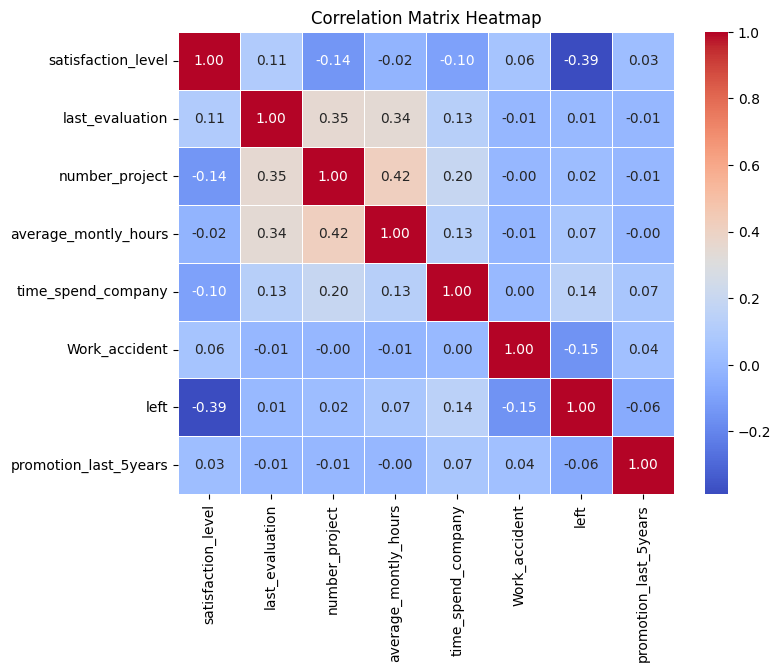

In [ ]:
# Select only numerical columns
numerical_data = data.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numerical_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

Create plots

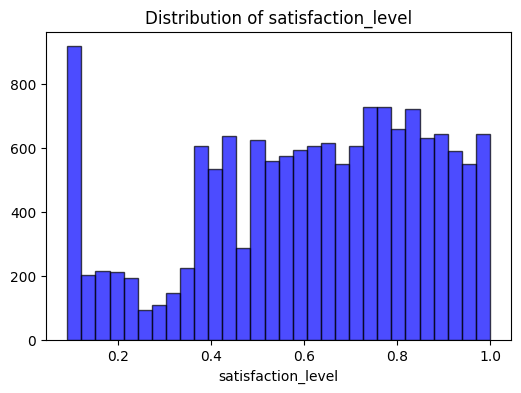

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(data["satisfaction_level"], bins=30, color='blue', edgecolor='black', alpha=0.7)

plt.title(f"Distribution of satisfaction_level")
plt.xlabel("satisfaction_level")
plt.show()

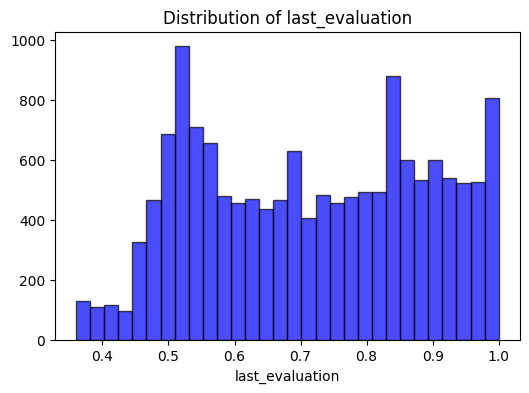

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(data["last_evaluation"], bins=30, color='blue', edgecolor='black', alpha=0.7)

plt.title(f"Distribution of last_evaluation")
plt.xlabel("last_evaluation")
plt.show()

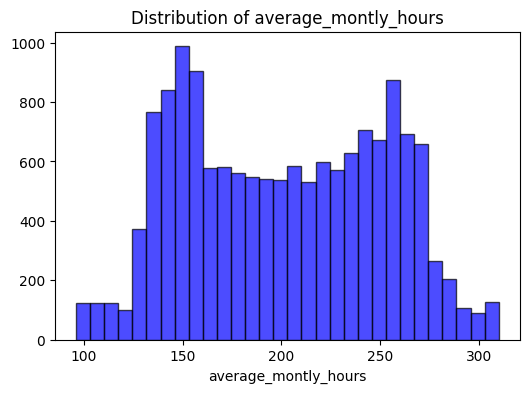

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(data["average_montly_hours"], bins=30, color='blue', edgecolor='black', alpha=0.7)

plt.title(f"Distribution of average_montly_hours")
plt.xlabel("average_montly_hours")
plt.show()

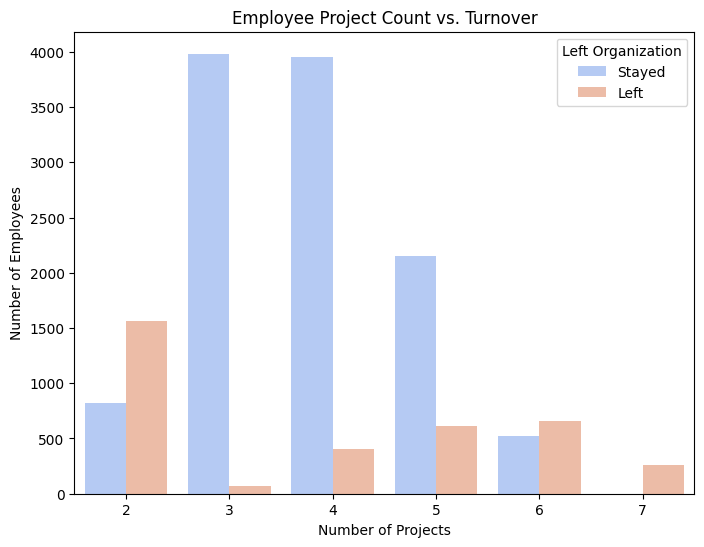

In [ ]:
# Plot bar chart using seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x='number_project', hue='left', data=data, palette='coolwarm')

# Labels and title
plt.title("Employee Project Count vs. Turnover")
plt.xlabel("Number of Projects")
plt.ylabel("Number of Employees")
plt.legend(title="Left Organization", labels=["Stayed", "Left"])

# Show plot
plt.show()

Perform clustering of employees who left based on their satisfaction and
evaluation.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
# Select employees who left
left_employees = data[data["left"] == 1][["satisfaction_level", "last_evaluation"]]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(left_employees)

# Apply K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
left_employees["Cluster"] = kmeans.fit_predict(scaled_data)


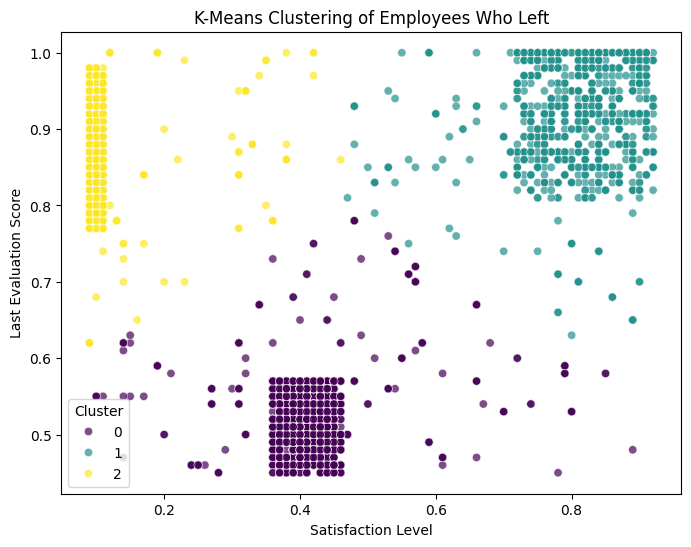

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=left_employees["satisfaction_level"],
    y=left_employees["last_evaluation"],
    hue=left_employees["Cluster"],
    palette="viridis",
    alpha=0.7
)
plt.title("K-Means Clustering of Employees Who Left")
plt.xlabel("Satisfaction Level")
plt.ylabel("Last Evaluation Score")
plt.legend(title="Cluster")
plt.show()

Handle the left Class Imbalance using the SMOTE technique

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [ ]:
# Separate categorical and numerical columns
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(include=['number']).columns
numerical_columns = numerical_columns.drop('left')

# Apply get_dummies to categorical variables
data_encoded = pd.get_dummies(data[categorical_columns], drop_first=True)

# Combine categorical and numerical variables
data_processed = pd.concat([data[numerical_columns], data_encoded], axis=1)

# Separate features (X) and target (y)
X = data_processed
y = data['left']

# Stratified Split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Initialize SMOTE and apply it to the training set
smote = SMOTE(random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after upsampling
print("Before SMOTE - Class distribution in training set:", y_train.value_counts())
print("After SMOTE - Class distribution in training set:", y_train_resampled.value_counts())



Before SMOTE - Class distribution in training set: left
0    9142
1    2857
Name: count, dtype: int64
After SMOTE - Class distribution in training set: left
0    9142
1    9142
Name: count, dtype: int64


In [ ]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

Perform K-fold cross-validation model training and evaluate performance

LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Initialize Logistic Regression model
logreg = LogisticRegression(random_state=123)

# K-Fold Cross-Validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Apply K-Fold Cross Validation
cv_results = cross_validate(logreg, X_train_resampled, y_train_resampled, cv=cv, scoring='accuracy', return_estimator=True)

# Print the cross-validation results
print("Cross-Validation Scores:", cv_results['test_score'])
print("Mean Cross-Validation Accuracy:", np.mean(cv_results['test_score']))



Cross-Validation Scores: [0.80010938 0.79409352 0.79928903 0.79546076 0.79020788]
Mean Cross-Validation Accuracy: 0.795832114185259


In [ ]:
# Train the model on the entire upsampled dataset and predict on the test set
logreg.fit(X_train_resampled, y_train_resampled)
y_pred_logreg = logreg.predict(X_test)

In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred_logreg, output_dict=True)

# Convert the classification report to a DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()

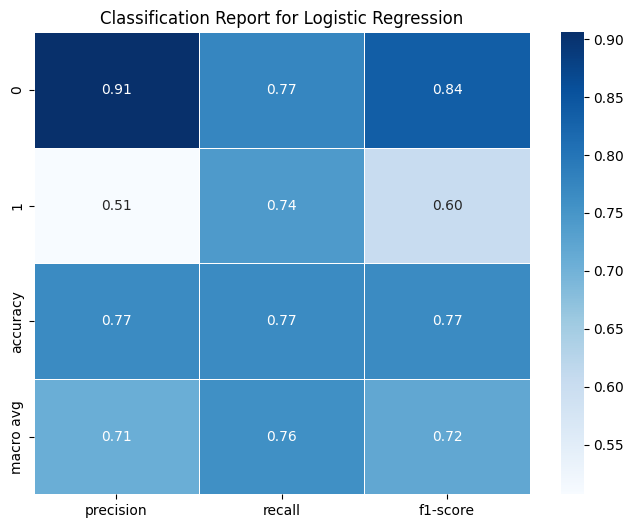

In [ ]:
# Plot the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title("Classification Report for Logistic Regression")
plt.show()

Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(random_state=123)
cv_results = cross_validate(rf, X_train_resampled, y_train_resampled, cv=cv, scoring='accuracy', return_estimator=True)
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_test)

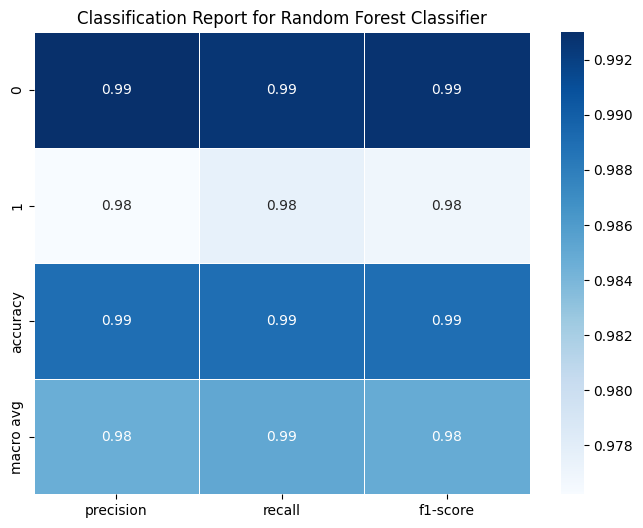

In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred_rf, output_dict=True)

# Convert the classification report to a DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()

# Plot the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title("Classification Report for Random Forest Classifier")
plt.show()

Gradient Boosting Classifier model

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb = GradientBoostingClassifier(random_state=123)

cv_results = cross_validate(gb, X_train_resampled, y_train_resampled, cv=cv, scoring='accuracy', return_estimator=True)
gb.fit(X_train_resampled, y_train_resampled)
y_pred_gb = gb.predict(X_test)

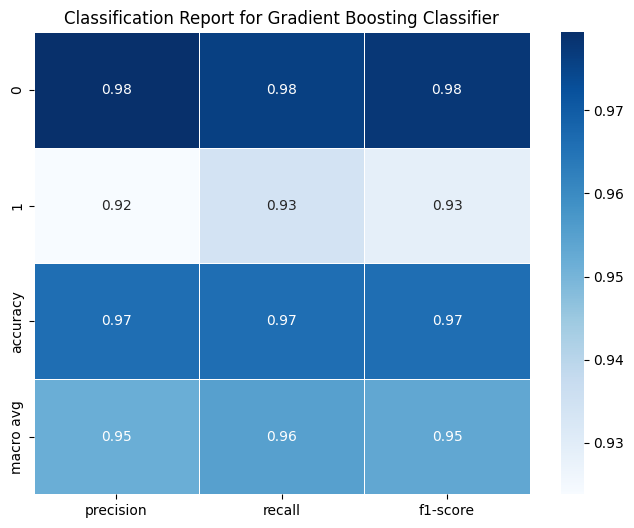

In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred_gb, output_dict=True)

# Convert the classification report to a DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()

# Plot the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title("Classification Report for Gradient Boosting Classifier")
plt.show()

Identify the best model and justify the evaluation metrics used

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

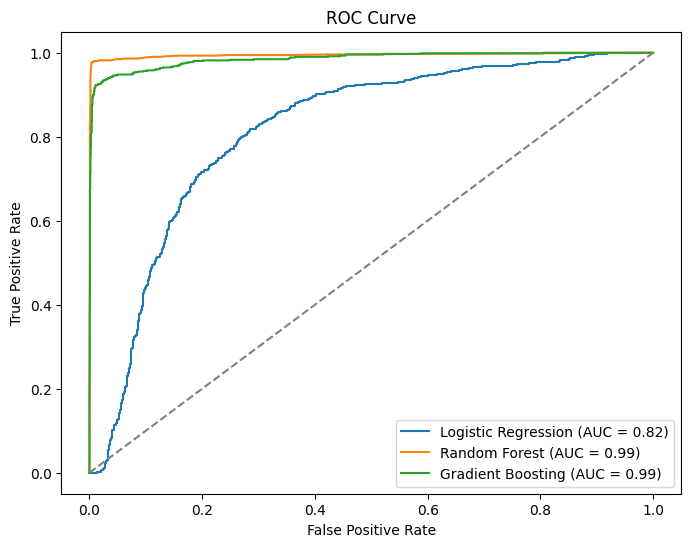

In [ ]:
# Logistic Regression ROC/AUC
roc_auc_logreg = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])

# Random Forest ROC/AUC
roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

# Gradient Boosting ROC/AUC
roc_auc_gb = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb.predict_proba(X_test)[:, 1])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

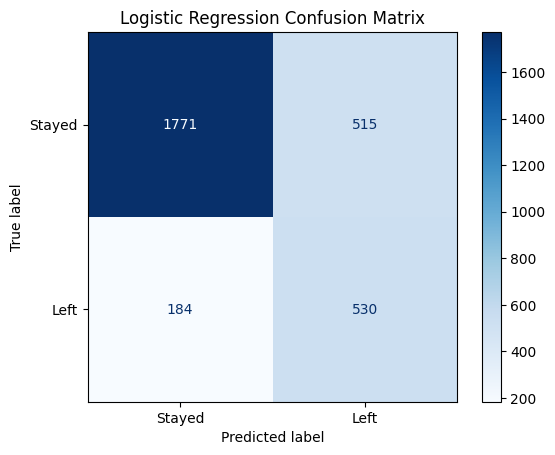

In [ ]:

cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Display Confusion Matrix for Logistic Regression
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=["Stayed", "Left"])
disp_logreg.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()


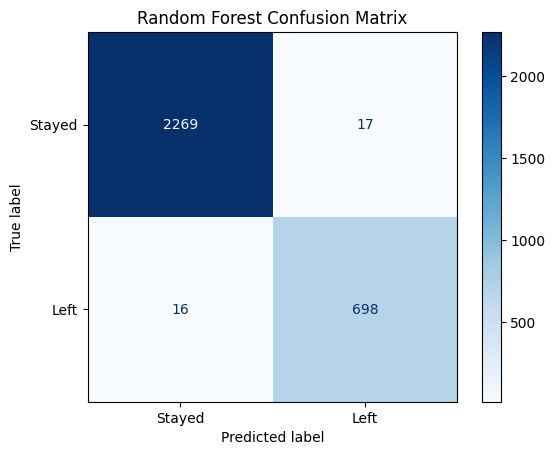

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Display Confusion Matrix for Random Forest
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Stayed", "Left"])
disp_rf.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

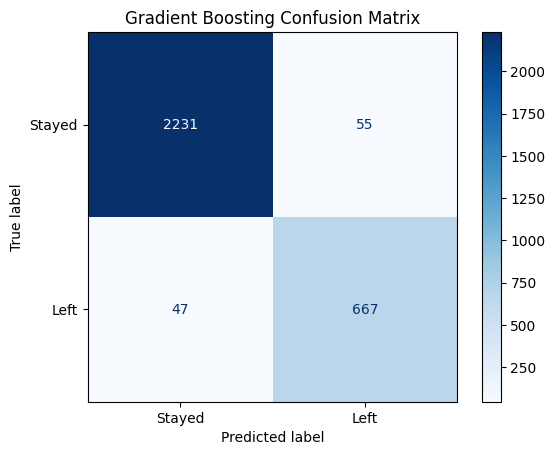

In [ ]:
cm_gb = confusion_matrix(y_test, y_pred_gb)

# Display Confusion Matrix for Gradient Boosting
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=["Stayed", "Left"])
disp_gb.plot(cmap='Blues')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

# Based on the above values from confusion matrix **Random forest** give **better result**

Suggest various retention strategies for targeted employees.

In [ ]:
print("Shape of y_prob:", y_prob.shape)
print("Shape of X_test:", X_test.shape)

Shape of y_prob: (3000,)
Shape of X_test: (3000, 18)


In [ ]:
# Using the best model to predict probabilities (replace 'gb' with your best model)
y_prob = rf.predict_proba(X_test)[:, 1]

X_test_df = pd.DataFrame(X_test)

# Add the probability scores to the test data for reference
X_test_df['turnover_probability'] = y_prob

# Preview the predictions
X_test_df[['turnover_probability']].head()

,turnover_probability
0,0.00
1,0.59
2,0.06
3,0.01
4,0.01


Categorize employees into risk zones based on the probability score

In [ ]:
def categorize_risk_zone(probability):
    if probability < 0.2:
        return 'Safe Zone (Green)'
    elif 0.2 <= probability < 0.6:
        return 'Low-Risk Zone (Yellow)'
    elif 0.6 <= probability < 0.9:
        return 'Medium-Risk Zone (Orange)'
    else:
        return 'High-Risk Zone (Red)'

# Apply the categorization to the test data
X_test_df['risk_zone'] = X_test_df['turnover_probability'].apply(categorize_risk_zone)

# Preview the results
X_test_df[['turnover_probability', 'risk_zone']].head()

,turnover_probability,risk_zone
0,0.00,Safe Zone (Green)
1,0.59,Low-Risk Zone (Yellow)
2,0.06,Safe Zone (Green)
3,0.01,Safe Zone (Green)
4,0.01,Safe Zone (Green)
